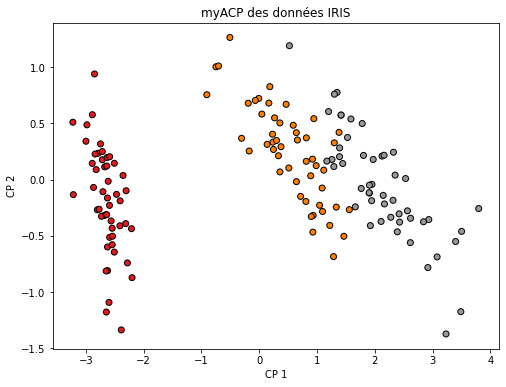

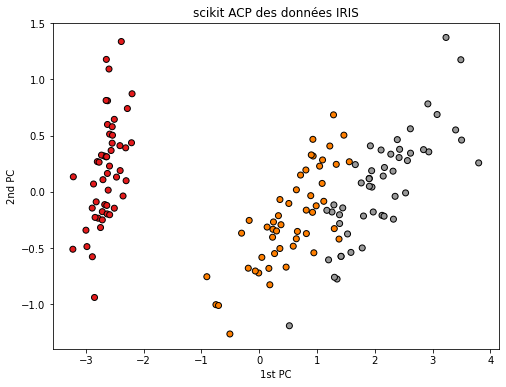

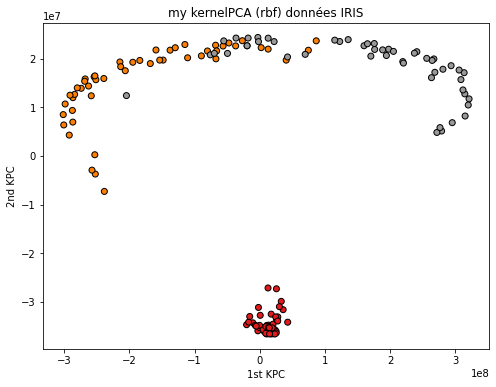

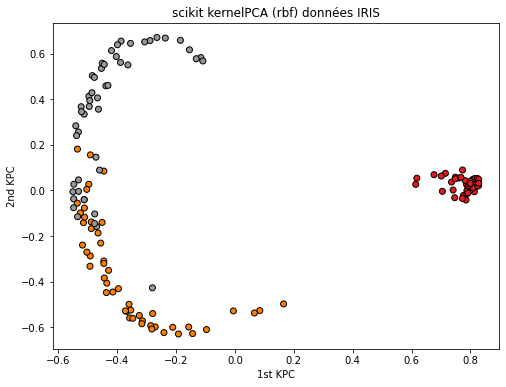

In [20]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
#
# M1 Science et Ingénieurie des données
# Université de Rouen Normandie
# T. Paquet 2022 Thierry.Paquet@univ-rouen.fr

import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler

import numpy as np
import scipy as sp #right=True.
from operator import itemgetter, attrgetter

def TriVP(Valp,Vectp):
    # trie dans l'ordre décroisant les valeurs propres
    # en cas de valeurs propres complexes on trie  selon leu module
    liste1 = Vectp.tolist()
    liste2 = Valp.tolist()
    norme = np.abs(Valp)
    liste3 = norme.tolist()

    result = zip(liste1, liste2,liste3)
    result_trie =sorted(result,key =itemgetter(2), reverse=True)
    liste1, liste2, liste3 =  zip(*result_trie)
    Vectp = np.asarray(liste1)
    Valp = np.asarray(liste2)
    
    return Valp,Vectp

def Kernel(XC,kernel='linear',gamma=0,degre=3):
    # Calcule de la matrice de Gram, sélection du noyau
    # valeurs par défaut : 
    # rbf :gamma = 1/n
    # polynomial : degre = 3,    c=1
    n = XC.shape[1]
    m = XC.shape[0]
    if kernel == 'linear':
        K = XC @ XC.T
    elif kernel == 'rbf':
        # valeur par défaut comme dans scikitlearn
        if gamma == 0:
            gamma = 1/n
            
        K = np.ones((m,m))
        for i in range(m):
            for j in range(i+1,m):
                K[i,j] = np.exp(-np.linalg.norm(XC[i,:]-XC[j,:])**2 * gamma)
                K[j,i] = K[i,j]
    elif kernel =='poly':
        PS = XC @ XC.T + np.ones((m,m))
        K = np.power(PS,degre)
        
    return K

def myACP(X):
    n = X.shape[1]
    m = X.shape[0]
    moy = np.sum(X,0)/m # axe de la matrice selon lequel on somme
    np.reshape(moy,(n,1))
    
    # données centrées
    XC = (X - moy)
    
    # covariance
    S = (1/m)*np.dot(XC.transpose(),XC)

    # calcule des valeurs propres et vecteurs propres
    # vecteurs propres de norme 1 rangés en colonnes    
    Valp, Vectp = np.linalg.eig(S)

    # il faut ordonner dans l'ordre des valeurs propres décroissantes
    Valp,Vectp = TriVP(Valp,Vectp)    

    # on projette sur les deux premiers axes principaux
    Projection = XC @ Vectp[:,0:2]
    
    return Projection

def myKernelPCA(X,kernel='linear',gamma=0,degre=3):
    n = X.shape[1]
    m = X.shape[0]
    moy = np.sum(X,0)/m # axe de la matrice selon lequel on somme
    np.reshape(moy,(n,1))

    # Etape 1: centrer les données
    XC = (X - moy)
    
    # Etape 2: calcule de la matrice de Gram, sélection du noyau
    K = Kernel(XC, kernel = kernel, gamma = gamma, degre = degre)
    
    # Etape 3: centrage des produits scalaires
    UN = np.ones((m,m))/m
    Ktild = K - UN@K - K@UN + UN@K@UN

    # Etape 4: calcule les vecteurs propres de Ktild 
    Valp, Vectp = np.linalg.eigh(Ktild)

    # Etape 5: il faut ordonner dans l'ordre des valeurs propres décroissantes
    #Valp,Vectp = TriVP(Valp,Vectp)
    
    # Etape 6: Extraction des coordonnées des deux premiers vecteurs propres dans l'espac de départ
    aj = np.diag(np.sqrt(Valp[-2:]))
    
    # Etape 7: Normalisation de pour avoir des vecteurs propres de l'espace projeté soient normée
    for i in range(2):
        norm_aj = np.linalg.norm(aj[:,[i]])
        aj[:,[i]] = aj[:,[i]] / np.sqrt( Valp[i].real) / norm_aj

    Y = Ktild@Vectp[:,-2:]@aj[-2:]
    
    return Y

    
if __name__ == '__main__':    

    #######################################################################
    iris = datasets.load_iris()
    y = iris.target

    #######################################################################
    #              ACP simple 
    Y = myACP(iris.data)    
            
    fig = plt.figure(1, figsize=(8, 6))
    plt.clf()
    plt.scatter(Y[:, 0], Y[:, 1], c=y, cmap=plt.cm.Set1,edgecolor='k')
    plt.xlabel('CP 1')
    plt.ylabel('CP 2')
    plt.title('myACP des données IRIS')
    plt.show()
    
    # on vérifie nos résultats de scikitlearn
    acp = PCA(n_components = 4, copy=True, iterated_power='auto', \
              random_state=None, svd_solver='full', tol=0.0, whiten=False)
    
    YY = acp.fit_transform(iris.data)

    fig = plt.figure(1, figsize=(8, 6))
    plt.clf()
    plt.scatter(YY[:, 0], YY[:, 1], c=y, cmap=plt.cm.Set1,edgecolor='k')
    plt.xlabel('1st PC')
    plt.ylabel('2nd PC')
    plt.title('scikit ACP des données IRIS')
    plt.show()
    
#    #######################################################################
#    # mon ACP à noyaux
#    #                    'linear'   'rbf'   'poly'
    Y = myKernelPCA(iris.data,kernel='rbf')
#    
    fig = plt.figure(1, figsize=(8, 6))
    plt.clf()
    plt.scatter(Y[:, 0], Y[:, 1], c=y, cmap=plt.cm.Set1,edgecolor='k')
    plt.xlabel('1st KPC')
    plt.ylabel('2nd KPC')
    plt.title('my kernelPCA (rbf) données IRIS')
    plt.show()
#    
#    # on fait une kernel PCA avec scikit learn
    kernelpca = KernelPCA(n_components=2, kernel='rbf')
    Y = kernelpca.fit_transform(iris.data)
#    
    fig = plt.figure(1, figsize=(8, 6))
    plt.clf()
    plt.scatter(Y[:, 0], Y[:, 1], c=y, cmap=plt.cm.Set1,edgecolor='k')
    plt.xlabel('1st KPC')
    plt.ylabel('2nd KPC')
    plt.title('scikit kernelPCA (rbf) données IRIS')
    plt.show()
    
